In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import random
import cv2
from PIL import Image
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.applications import EfficientNetB0, MobileNetV2, ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

Vérification du chemin des données: ../data/african_plums_dataset
Catégories identifiées : ['bruised', 'cracked', 'rotten', 'spotted', 'unaffected', 'unripe']
Vérification de l'intégrité du dataset...
Toutes les 4507 images sont valides!
Catégorie 'bruised': 319 images
Catégorie 'cracked': 162 images
Catégorie 'rotten': 720 images
Catégorie 'spotted': 759 images
Catégorie 'unaffected': 1721 images
Catégorie 'unripe': 826 images

Nombre total d'images: 4507


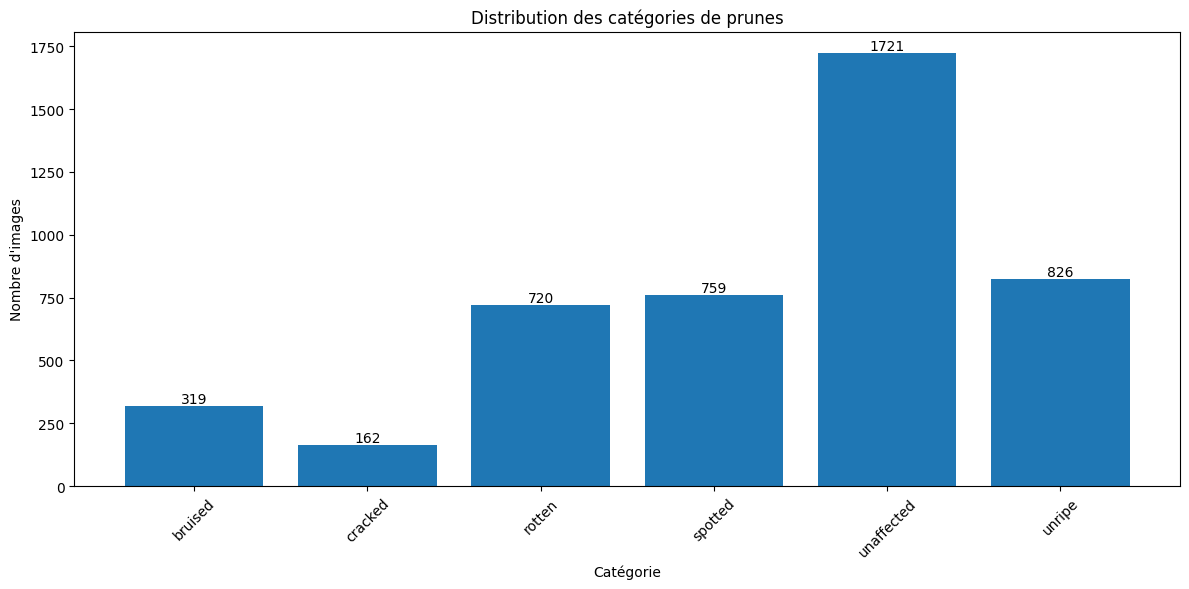

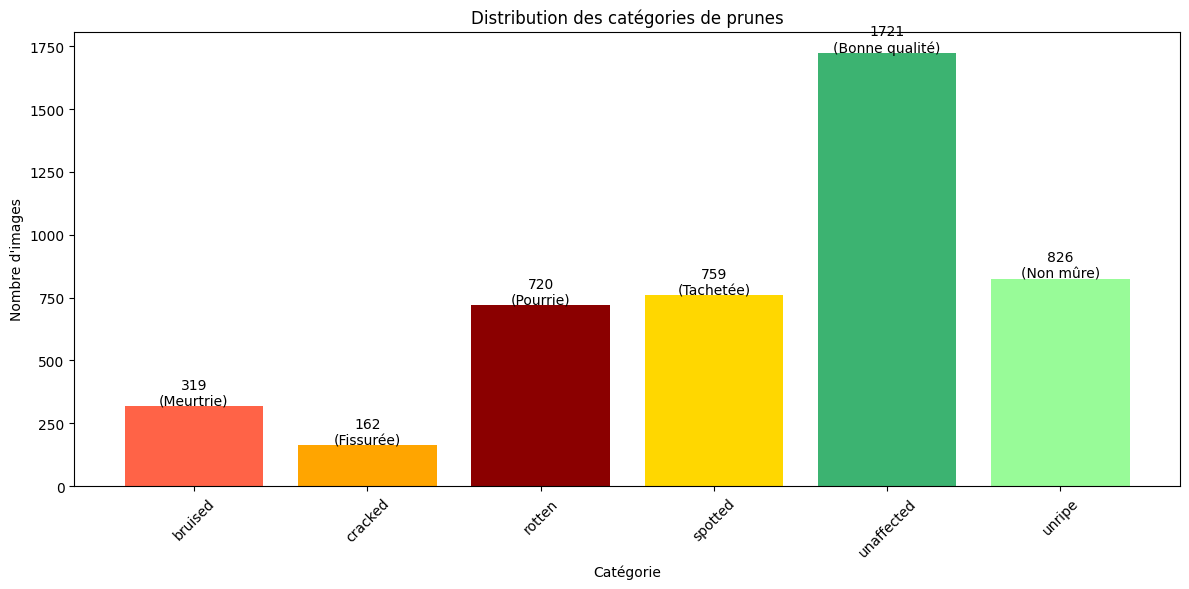

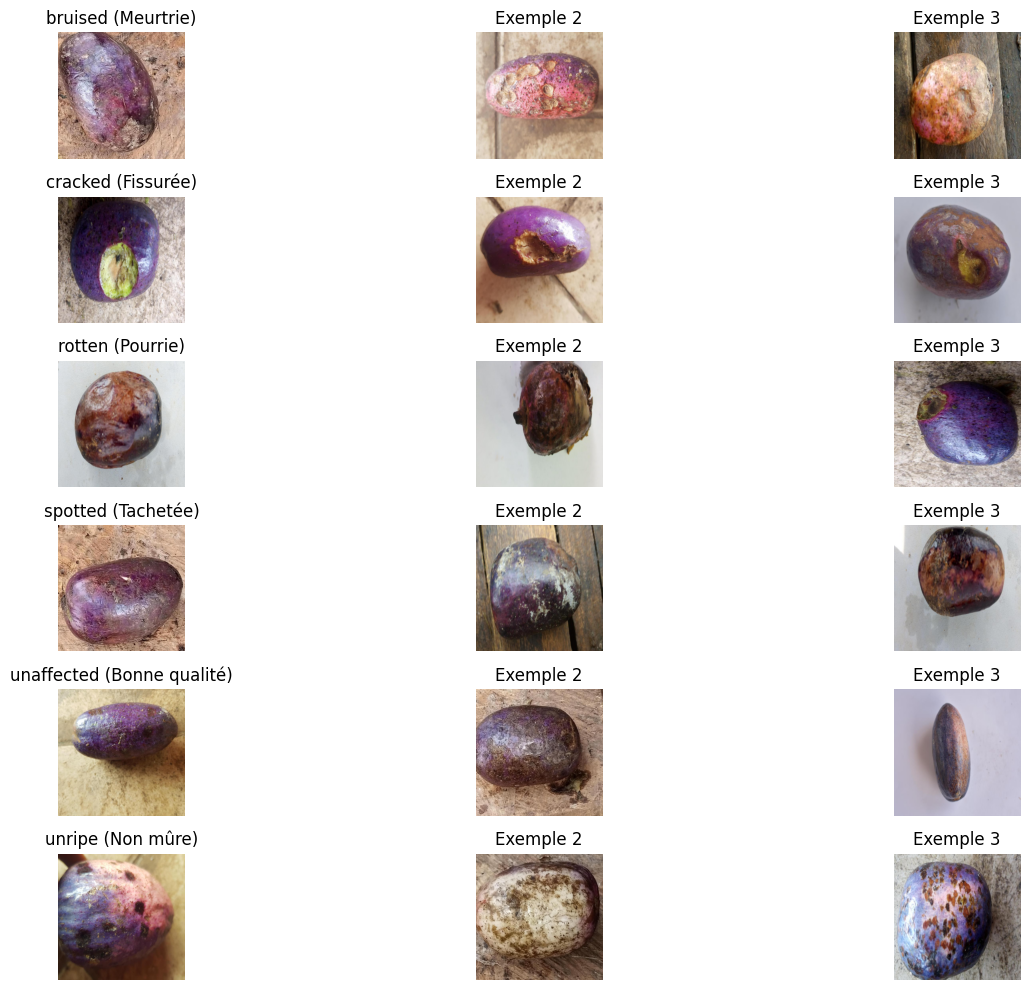


Statistiques par catégorie:
    Catégorie   Nom français  Nombre d'images  Pourcentage
0     bruised       Meurtrie              319         7.08
1     cracked       Fissurée              162         3.59
2      rotten        Pourrie              720        15.98
3     spotted       Tachetée              759        16.84
4  unaffected  Bonne qualité             1721        38.19
5      unripe       Non mûre              826        18.33
Statistiques sauvegardées dans ../models\statistics.csv


In [4]:
 # Configuration pour éviter les warnings et configurer la GPU
import warnings
warnings.filterwarnings('ignore')

# Définir les graines aléatoires pour la reproductibilité
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Configuration des chemins et des paramètres
# Chemin vers le dossier de données
DATA_DIR = "../data/african_plums_dataset"  # Modifiez ce chemin pour qu'il pointe vers votre dossier de données

# Chemin pour sauvegarder le modèle
MODEL_DIR = "../models"
if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)

# Paramètres d'entraînement
IMG_SIZE = 224  # Taille des images
BATCH_SIZE = 32  # Taille du batch
EPOCHS = 20  # Nombre d'époques d'entraînement
LEARNING_RATE = 1e-4  # Taux d'apprentissage

# Fonction pour charger une image de manière sécurisée
def safe_load_image(image_path):
    try:
        # Essayer de charger avec PIL (plus robuste)
        img = Image.open(image_path)
        # Convertir en numpy array pour matplotlib
        img_array = np.array(img)
        return img_array
    except Exception as e:
        print(f"Erreur lors du chargement de {image_path}: {e}")
        # Retourner une image vide en cas d'échec (rouge pour indiquer l'erreur)
        return np.ones((100, 100, 3), dtype=np.uint8) * np.array([255, 0, 0], dtype=np.uint8)

# Fonction pour vérifier l'intégrité du dataset
def check_dataset_integrity(data_dir):
    """Vérifie l'intégrité de toutes les images dans le dataset"""
    print("Vérification de l'intégrité du dataset...")
    corrupted_files = []
    
    categories = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]
    total_files = 0
    
    for category in categories:
        category_path = os.path.join(data_dir, category)
        images = [f for f in os.listdir(category_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        total_files += len(images)
        
        for img_file in images:
            img_path = os.path.join(category_path, img_file)
            try:
                with Image.open(img_path) as img:
                    # Vérifier si l'image peut être chargée et convertie
                    img.verify()
            except Exception as e:
                corrupted_files.append((img_path, str(e)))
    
    if corrupted_files:
        print(f"Trouvé {len(corrupted_files)} fichiers corrompus sur {total_files} images:")
        for file, error in corrupted_files[:10]:  # Limiter l'affichage aux 10 premiers
            print(f"  - {file}: {error}")
        if len(corrupted_files) > 10:
            print(f"  ... et {len(corrupted_files) - 10} autres fichiers")
    else:
        print(f"Toutes les {total_files} images sont valides!")
    
    return corrupted_files

# Exploration et analyse des données
print(f"Vérification du chemin des données: {DATA_DIR}")

# Vérifier si le dossier de données existe
if not os.path.exists(DATA_DIR):
    raise FileNotFoundError(f"Le dossier {DATA_DIR} n'existe pas.")

# Obtenir la liste des catégories (sous-dossiers)
categories = [d for d in os.listdir(DATA_DIR) if os.path.isdir(os.path.join(DATA_DIR, d))]
print(f"Catégories identifiées : {categories}")

# Vérifier l'intégrité du dataset
corrupted_files = check_dataset_integrity(DATA_DIR)

# Compter le nombre d'images par catégorie
image_counts = {}
for category in categories:
    category_path = os.path.join(DATA_DIR, category)
    images = [f for f in os.listdir(category_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    image_counts[category] = len(images)
    print(f"Catégorie '{category}': {len(images)} images")

print(f"\nNombre total d'images: {sum(image_counts.values())}")

# Visualiser la distribution des catégories
plt.figure(figsize=(12, 6))
bars = plt.bar(image_counts.keys(), image_counts.values())

# Ajouter les valeurs sur les barres
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
            f'{height}',
            ha='center', va='bottom')

plt.title('Distribution des catégories de prunes')
plt.xlabel('Catégorie')
plt.ylabel('Nombre d\'images')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(MODEL_DIR, 'distribution.png'))
plt.show()

# Créer un dictionnaire pour les noms français des catégories
category_names_fr = {
    'unaffected': 'Bonne qualité',
    'unripe': 'Non mûre',
    'spotted': 'Tachetée',
    'cracked': 'Fissurée',
    'bruised': 'Meurtrie',
    'rotten': 'Pourrie'
}

# Créer un dictionnaire pour les couleurs des catégories
category_colors = {
    'unaffected': '#3CB371',  # Vert
    'unripe': '#98FB98',      # Vert clair
    'spotted': '#FFD700',     # Jaune
    'cracked': '#FFA500',     # Orange
    'bruised': '#FF6347',     # Rouge-orangé
    'rotten': '#8B0000'       # Rouge foncé
}

# Visualiser la distribution des catégories avec couleurs
plt.figure(figsize=(12, 6))
bars = plt.bar(
    image_counts.keys(), 
    image_counts.values(),
    color=[category_colors.get(category, '#1f77b4') for category in image_counts.keys()]
)

# Ajouter les valeurs et les noms français sur les barres
for i, (category, count) in enumerate(image_counts.items()):
    plt.text(
        i, count + 5, 
        f"{count}\n({category_names_fr.get(category, category)})",
        ha='center'
    )

plt.title('Distribution des catégories de prunes')
plt.xlabel('Catégorie')
plt.ylabel('Nombre d\'images')
plt.xticks(range(len(categories)), categories, rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(MODEL_DIR, 'distribution_color.png'))
plt.show()

# Visualiser quelques exemples d'images pour chaque catégorie
fig = plt.figure(figsize=(15, 10))

# Définir le nombre de lignes et de colonnes
rows = len(categories)
cols = 3

for i, category in enumerate(categories):
    category_path = os.path.join(DATA_DIR, category)
    images = [f for f in os.listdir(category_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    
    if not images:
        print(f"Aucune image trouvée pour la catégorie {category}")
        continue
    
    # Sélectionner 3 images aléatoires (ou moins si pas assez d'images)
    sample_size = min(cols, len(images))
    samples = random.sample(images, sample_size)
    
    # Créer un sous-titre pour la catégorie
    category_title = f"{category} ({category_names_fr.get(category, category)})"
    
    for j, sample in enumerate(samples):
        # Calculer l'indice du subplot
        plt_idx = i * cols + j + 1
        
        ax = fig.add_subplot(rows, cols, plt_idx)
        img_path = os.path.join(category_path, sample)
        
        # Utiliser notre fonction de chargement sécurisé
        img = safe_load_image(img_path)
        
        ax.imshow(img)
        
        # Ajouter le titre de la catégorie seulement pour la première image de chaque ligne
        if j == 0:
            ax.set_title(category_title)
        # Sinon, ajouter juste un numéro d'exemple
        else:
            ax.set_title(f"Exemple {j+1}")
            
        ax.axis('off')

plt.tight_layout()
plt.savefig(os.path.join(MODEL_DIR, 'sample_images.png'))
plt.show()

# Afficher quelques statistiques supplémentaires
print("\nStatistiques par catégorie:")
stats_data = []
for category in categories:
    stats_data.append({
        'Catégorie': category,
        'Nom français': category_names_fr.get(category, category),
        'Nombre d\'images': image_counts[category],
        'Pourcentage': round(image_counts[category] / sum(image_counts.values()) * 100, 2)
    })

stats_df = pd.DataFrame(stats_data)
print(stats_df)

# Sauvegarder les statistiques dans un fichier CSV
stats_df.to_csv(os.path.join(MODEL_DIR, 'statistics.csv'), index=False)
print(f"Statistiques sauvegardées dans {os.path.join(MODEL_DIR, 'statistics.csv')}")

In [6]:
# 4. Prétraitement des données et création des générateurs

# Créer les listes d'images et de labels
image_paths = []
labels = []

# Parcourir chaque catégorie
for i, category in enumerate(categories):
    category_path = os.path.join(DATA_DIR, category)
    images = [f for f in os.listdir(category_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    
    for image in images:
        image_paths.append(os.path.join(category_path, image))
        labels.append(i)

# Convertir en tableaux numpy
image_paths = np.array(image_paths)
labels = np.array(labels)

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(image_paths, labels, test_size=0.2, random_state=SEED, stratify=labels)

# Diviser les données d'entraînement en ensembles d'entraînement et de validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=SEED, stratify=y_train)

print(f"Ensemble d'entraînement: {len(X_train)} images")
print(f"Ensemble de validation: {len(X_val)} images")
print(f"Ensemble de test: {len(X_test)} images")


Ensemble d'entraînement: 2884 images
Ensemble de validation: 721 images
Ensemble de test: 902 images


In [7]:
# Fonction pour prétraiter une image
def preprocess_image(image_path, target_size=(IMG_SIZE, IMG_SIZE)):
    # Charger l'image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convertir de BGR à RGB
    
    # Redimensionner l'image
    img = cv2.resize(img, target_size)
    
    # Normaliser les valeurs de pixels entre 0 et 1
    img = img / 255.0
    
    return img

# Créer les générateurs de données
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, image_paths, labels, batch_size=BATCH_SIZE, img_size=(IMG_SIZE, IMG_SIZE), n_classes=len(categories), shuffle=True, augment=False):
        self.image_paths = image_paths
        self.labels = labels
        self.batch_size = batch_size
        self.img_size = img_size
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.augment = augment
        self.on_epoch_end()
        
    def __len__(self):
        return int(np.ceil(len(self.image_paths) / self.batch_size))
    
    def __getitem__(self, index):
        # Générer les indices pour le batch
        indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        
        # Obtenir les chemins d'image et les labels pour ce batch
        batch_image_paths = [self.image_paths[i] for i in indices]
        batch_labels = [self.labels[i] for i in indices]
        
        # Générer le batch de données
        X, y = self._generate_data(batch_image_paths, batch_labels)
        
        return X, y
    
    def on_epoch_end(self):
        self.indices = np.arange(len(self.image_paths))
        if self.shuffle:
            np.random.shuffle(self.indices)
    
    def _generate_data(self, batch_image_paths, batch_labels):
        X = np.empty((len(batch_image_paths), *self.img_size, 3))
        y = np.empty(len(batch_image_paths), dtype=int)
        
        # Générer les données
        for i, (image_path, label) in enumerate(zip(batch_image_paths, batch_labels)):
            # Prétraiter l'image
            X[i,] = preprocess_image(image_path, self.img_size)
            
            # Augmentation des données si nécessaire
            if self.augment:
                # Appliquer des transformations aléatoires
                pass
            
            # Stocker la classe
            y[i] = label
        
        return X, tf.keras.utils.to_categorical(y, num_classes=self.n_classes)

# Créer les générateurs
train_generator = DataGenerator(X_train, y_train, augment=True, shuffle=True)
val_generator = DataGenerator(X_val, y_val, shuffle=False)
test_generator = DataGenerator(X_test, y_test, shuffle=False)


In [11]:
# 5. Création du modèle

# Fonction pour créer un modèle EfficientNetB0 avec transfert d'apprentissage
def create_efficientnet_model(input_shape=(IMG_SIZE, IMG_SIZE, 3), num_classes=len(categories)):
    # Charger le modèle EfficientNetB0 pré-entraîné
    base_model = EfficientNetB0(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )
    
    # Geler les couches du modèle de base
    base_model.trainable = False
    
    # Créer le modèle complet
    inputs = Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.2)(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs, outputs)
    
    # Compiler le modèle
    model.compile(
        optimizer=Adam(learning_rate=LEARNING_RATE),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model, base_model

# Créer le modèle
model, base_model = create_efficientnet_model()

# Résumé du modèle
model.summary()

# 6. Définition des callbacks

# Callbacks pour l'entraînement
#callbacks = [
    # Sauvegarde le meilleur modèle
 #   ModelCheckpoint(
  #      filepath=os.path.join(MODEL_DIR, 'plum_classifier_best.h5'),
   #     monitor='val_accuracy',
    #    save_best_only=True,
     #   mode='max',
      #  verbose=1
    #),
    # Arrête l'entraînement si aucune amélioration n'est observée
    #EarlyStopping(
     #   monitor='val_accuracy',
      #  patience=5,
       # restore_best_weights=True,
        #verbose=1
   # ),
    # Réduit le taux d'apprentissage si aucune amélioration n'est observée
    #ReduceLROnPlateau(
     #   monitor='val_loss',
      #  factor=0.2,
       # patience=3,
        #min_lr=1e-6,
        #verbose=1
    #)
#]


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_2 (Dropout)         (None, 1280)              0         
                                                                 
 dense_2 (Dense)             (None, 512)               655872    
                                                                 
 batch_normalization_1 (Batc  (None, 512)              2048      
 hNormalization)                                           

In [13]:
 # 6. Définition des callbacks

# Callbacks pour l'entraînement

callbacks = [
    # Sauvegarde le meilleur modèle
    ModelCheckpoint(
        filepath=os.path.join(MODEL_DIR, 'plum_classifier_best.h5'),
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1,
        save_weights_only=True  # Ajouter cette ligne
    ),
    # Reste des callbacks inchangé
    EarlyStopping(
        monitor='val_accuracy',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=1e-6,
        verbose=1
    )
]

# 7. Entraînement du modèle - Phase 1 (Feature Extraction)

# Entraînement du modèle (feature extraction)
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,  # Moins d'époques pour la phase de feature extraction
    callbacks=callbacks,
    verbose=1
)

# 8. Fine-tuning du modèle - Phase 2 (Fine-tuning)

# Dégeler certaines couches pour le fine-tuning
base_model.trainable = True

# Geler les premières couches et dégeler les dernières
for layer in base_model.layers[:-30]:  # Geler toutes les couches sauf les 30 dernières
    layer.trainable = False
    
# Recompiler le modèle avec un taux d'apprentissage plus faible
model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE / 10),  # Taux d'apprentissage réduit pour le fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Résumé du modèle après le dégel des couches
print(f"Nombre de couches entraînables: {len([layer for layer in model.layers if layer.trainable])}/{len(model.layers)}")

# Fine-tuning du modèle
history_fine = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,  # Plus d'époques pour le fine-tuning
    callbacks=callbacks,
    verbose=1
)

# Sauvegarder le modèle final
#model.save(os.path.join(MODEL_DIR, 'plum_classifier_final.h5'))
#print(f"Modèle sauvegardé dans {os.path.join(MODEL_DIR, 'plum_classifier_final.h5')}")

try:
    model.save(os.path.join(MODEL_DIR, 'plum_classifier_final'))  # Sans extension .h5
    print(f"Modèle sauvegardé dans {os.path.join(MODEL_DIR, 'plum_classifier_final')}")
except Exception as e:
    print(f"Erreur lors de la sauvegarde du modèle: {str(e)}")

Epoch 1/10
91/91 [==============================] - ETA: 0s - loss: 2.1083 - accuracy: 0.1897
Epoch 1: val_accuracy improved from -inf to 0.38141, saving model to ../models\plum_classifier_best.h5
91/91 [==============================] - 101s 1s/step - loss: 2.1083 - accuracy: 0.1897 - val_loss: 1.7248 - val_accuracy: 0.3814 - lr: 2.0000e-06
Epoch 2/10
91/91 [==============================] - ETA: 0s - loss: 2.1124 - accuracy: 0.1862
Epoch 2: val_accuracy did not improve from 0.38141
91/91 [==============================] - 99s 1s/step - loss: 2.1124 - accuracy: 0.1862 - val_loss: 1.7234 - val_accuracy: 0.3814 - lr: 2.0000e-06
Epoch 3/10
91/91 [==============================] - ETA: 0s - loss: 2.1377 - accuracy: 0.1859
Epoch 3: val_accuracy did not improve from 0.38141
91/91 [==============================] - 96s 1s/step - loss: 2.1377 - accuracy: 0.1859 - val_loss: 1.7214 - val_accuracy: 0.3814 - lr: 2.0000e-06
Epoch 4/10
91/91 [==============================] - ETA: 0s - loss: 2.1080

INFO:tensorflow:Assets written to: ../models\plum_classifier_final\assets


INFO:tensorflow:Assets written to: ../models\plum_classifier_final\assets


Erreur lors de la sauvegarde du modèle: Unable to serialize [2.0896919 2.1128857 2.1081853] to JSON. Unrecognized type <class 'tensorflow.python.framework.ops.EagerTensor'>.


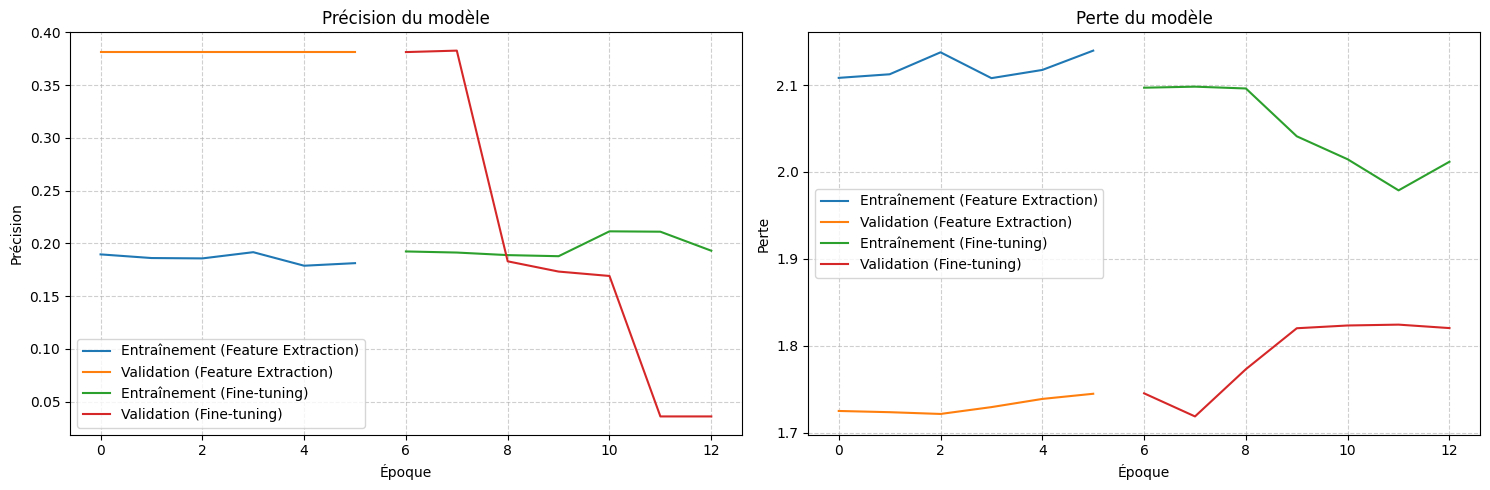

Historique d'entraînement sauvegardé dans ../models\training_history.png
29/29 [==============================] - 25s 838ms/step - loss: 1.7181 - accuracy: 0.3958
Loss sur l'ensemble de test: 1.7181
Accuracy sur l'ensemble de test: 0.3958
29/29 [==============================] - 21s 732ms/step
Rapport de classification:

              precision    recall  f1-score   support

     bruised       0.00      0.00      0.00        64
     cracked       0.00      0.00      0.00        32
      rotten       0.00      0.00      0.00       144
     spotted       0.00      0.00      0.00       152
  unaffected       0.40      0.94      0.56       345
      unripe       0.34      0.21      0.26       165

    accuracy                           0.40       902
   macro avg       0.12      0.19      0.14       902
weighted avg       0.22      0.40      0.26       902



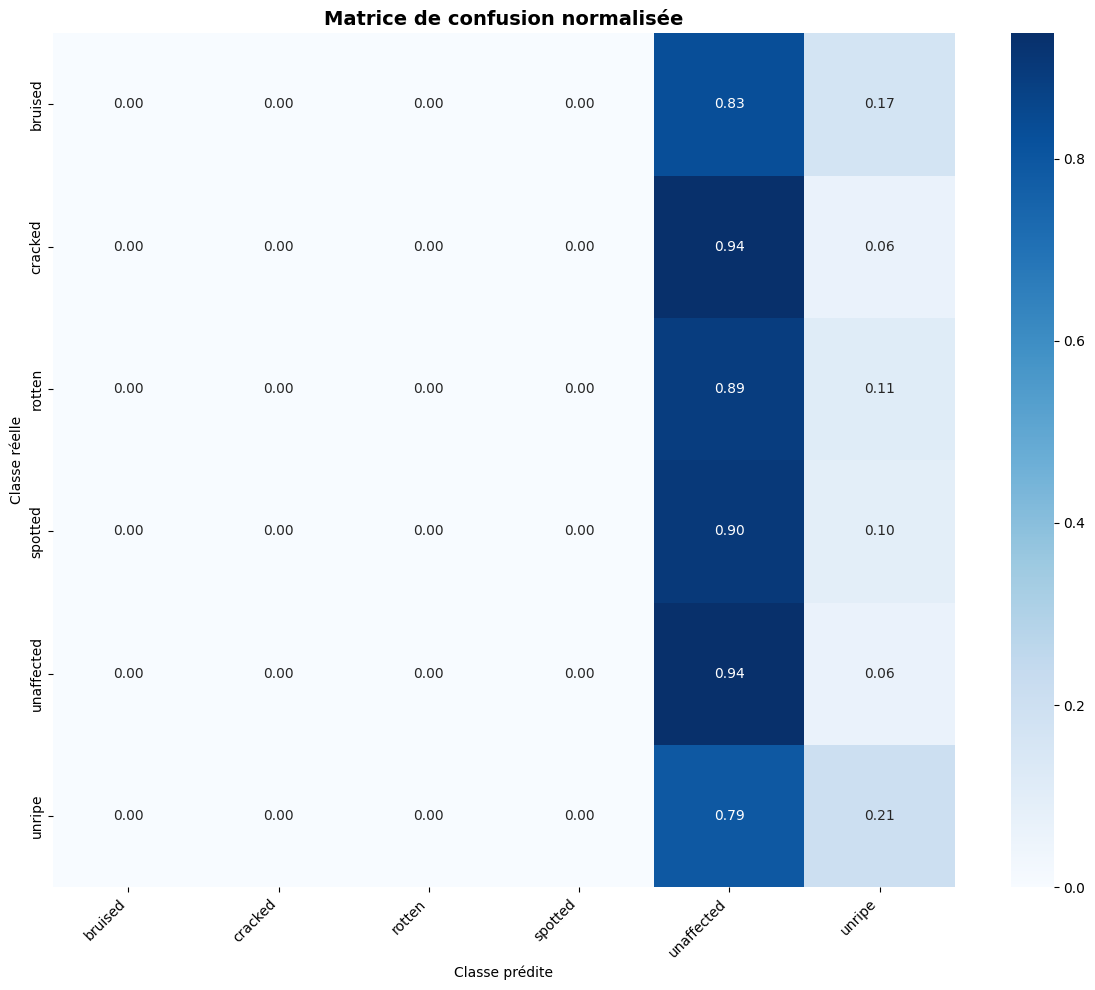

Matrice de confusion sauvegardée dans ../models\confusion_matrix.png


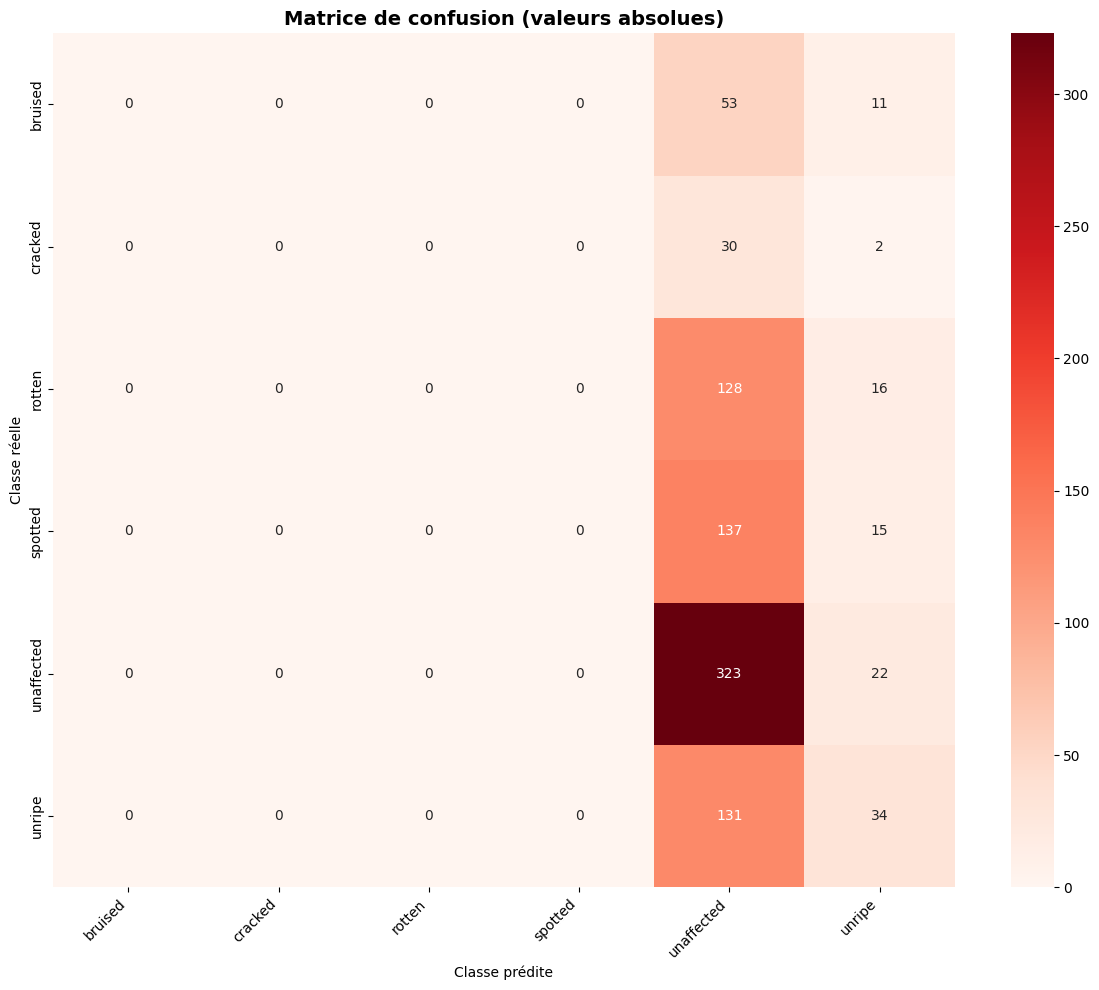

Matrice de confusion (valeurs absolues) sauvegardée dans ../models\confusion_matrix_absolute.png
1/1 [==============================] - 0s 62ms/step
Figure de prédictions sauvegardée dans ../models\prediction_examples.png


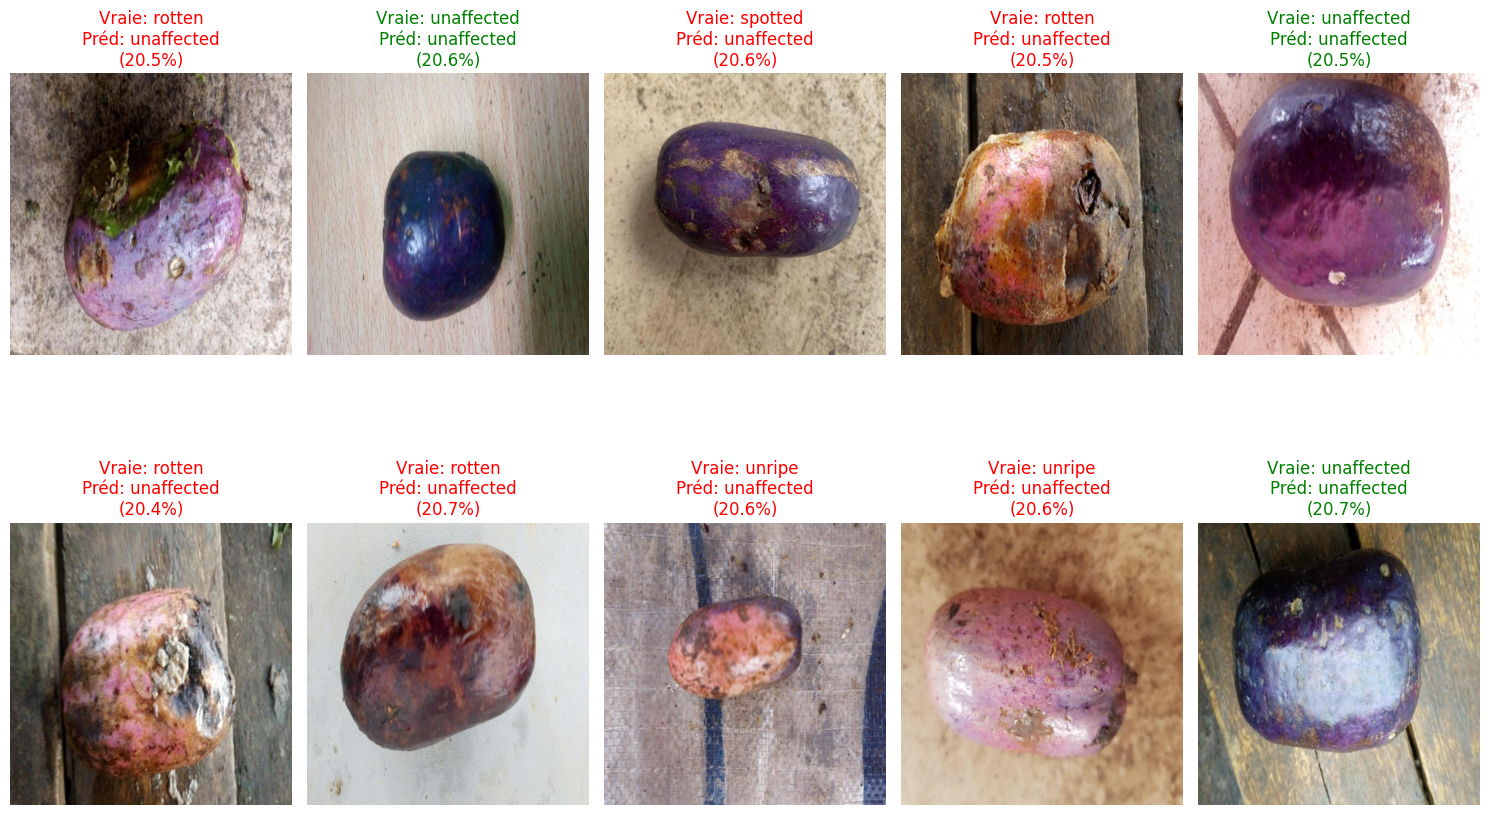

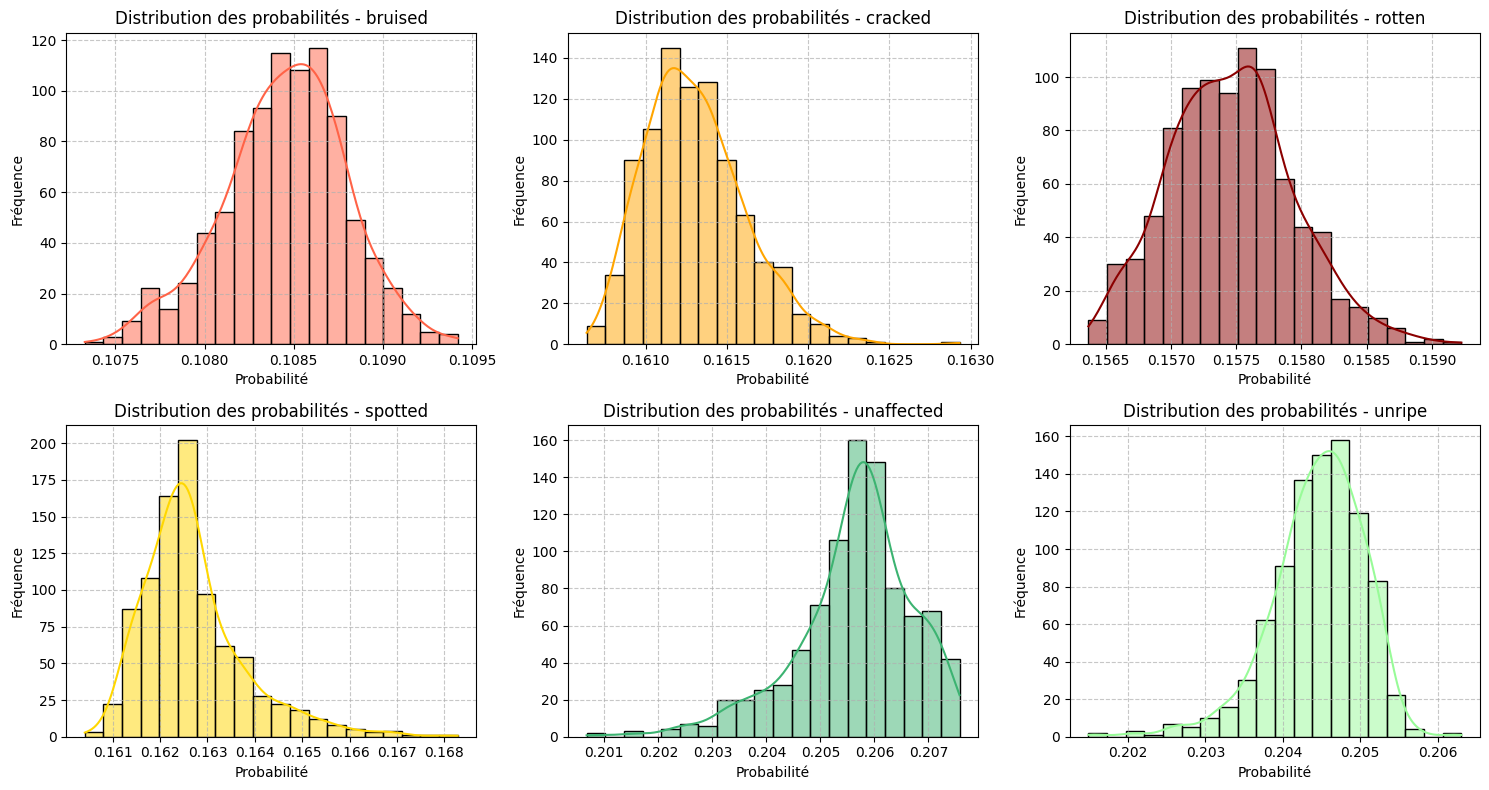

Distributions de probabilités sauvegardées dans ../models\probability_distributions.png

RÉSUMÉ DES PERFORMANCES DU MODÈLE
Accuracy sur l'ensemble de test: 0.3958
Loss sur l'ensemble de test: 1.7181
F1-score moyen: 0.2624
Précision moyenne: 0.2162
Rappel moyen: 0.3958

Performances par catégorie:
--------------------------------------------------
Catégorie    Précision  Rappel     F1-Score  
--------------------------------------------------
bruised      0.0000     0.0000     0.0000    
cracked      0.0000     0.0000     0.0000    
rotten       0.0000     0.0000     0.0000    
spotted      0.0000     0.0000     0.0000    
unaffected   0.4027     0.9362     0.5632    
unripe       0.3400     0.2061     0.2566    

Résumé des performances sauvegardé dans ../models\performance_summary.txt


In [18]:
# 9. Visualisation de l'historique d'entraînement

# Fonction pour visualiser l'historique d'entraînement
def plot_training_history(history, history_fine=None):
    """
    Visualise l'historique d'entraînement du modèle
    
    Args:
        history: Historique de la première phase d'entraînement
        history_fine: Historique de la phase de fine-tuning (optionnel)
    """
    try:
        # Créer la figure
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Tracer la précision
        ax1.plot(history.history['accuracy'], label='Entraînement (Feature Extraction)')
        ax1.plot(history.history['val_accuracy'], label='Validation (Feature Extraction)')
        
        if history_fine is not None:
            # Ajouter les courbes du fine-tuning
            epochs_fine = range(len(history.history['accuracy']), len(history.history['accuracy']) + len(history_fine.history['accuracy']))
            ax1.plot(epochs_fine, history_fine.history['accuracy'], label='Entraînement (Fine-tuning)')
            ax1.plot(epochs_fine, history_fine.history['val_accuracy'], label='Validation (Fine-tuning)')
        
        ax1.set_title('Précision du modèle')
        ax1.set_ylabel('Précision')
        ax1.set_xlabel('Époque')
        ax1.legend()
        ax1.grid(True, linestyle='--', alpha=0.6)
        
        # Tracer la perte
        ax2.plot(history.history['loss'], label='Entraînement (Feature Extraction)')
        ax2.plot(history.history['val_loss'], label='Validation (Feature Extraction)')
        
        if history_fine is not None:
            # Ajouter les courbes du fine-tuning
            ax2.plot(epochs_fine, history_fine.history['loss'], label='Entraînement (Fine-tuning)')
            ax2.plot(epochs_fine, history_fine.history['val_loss'], label='Validation (Fine-tuning)')
        
        ax2.set_title('Perte du modèle')
        ax2.set_ylabel('Perte')
        ax2.set_xlabel('Époque')
        ax2.legend()
        ax2.grid(True, linestyle='--', alpha=0.6)
        
        plt.tight_layout()
        plt.savefig(os.path.join(MODEL_DIR, 'training_history.png'))
        plt.show()
        
        print(f"Historique d'entraînement sauvegardé dans {os.path.join(MODEL_DIR, 'training_history.png')}")
    except Exception as e:
        print(f"Erreur lors de la visualisation de l'historique d'entraînement: {e}")

# Visualiser l'historique d'entraînement
plot_training_history(history, history_fine)

# 10. Évaluation du modèle sur l'ensemble de test

try:
    # Évaluer le modèle sur l'ensemble de test
    test_loss, test_accuracy = model.evaluate(test_generator)
    print(f"Loss sur l'ensemble de test: {test_loss:.4f}")
    print(f"Accuracy sur l'ensemble de test: {test_accuracy:.4f}")

    # Prédictions sur l'ensemble de test
    y_pred_probs = model.predict(test_generator)
    y_pred = np.argmax(y_pred_probs, axis=1)

    # Convertir les labels réels (qui sont dans le générateur)
    y_true = []
    for i in range(len(test_generator)):
        _, batch_y = test_generator[i]
        y_true.extend(np.argmax(batch_y, axis=1))
    y_true = y_true[:len(y_pred)]  # S'assurer que les longueurs correspondent

    # Rapport de classification
    print("Rapport de classification:\n")
    report = classification_report(y_true, y_pred, target_names=categories)
    print(report)
    
    # Sauvegarder le rapport dans un fichier
    with open(os.path.join(MODEL_DIR, 'classification_report.txt'), 'w') as f:
        f.write(report)

    # Matrice de confusion
    conf_matrix = confusion_matrix(y_true, y_pred)
    
    # Sauvegarder la matrice brute
    np.save(os.path.join(MODEL_DIR, 'confusion_matrix.npy'), conf_matrix)

    # Normaliser la matrice de confusion
    conf_matrix_norm = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
    
    # Figure pour la matrice de confusion
    plt.figure(figsize=(12, 10))
    
    # Utiliser un fond blanc pour la heatmap
    with plt.style.context({'axes.facecolor':'white'}):
        heatmap = sns.heatmap(
            conf_matrix_norm,
            annot=True,
            fmt='.2f',
            cmap='Blues',
            xticklabels=categories,
            yticklabels=categories,
            cbar=True
        )
    
    # Ajouter des labels et un titre
    plt.xlabel('Classe prédite')
    plt.ylabel('Classe réelle')
    plt.title('Matrice de confusion normalisée', fontsize=14, fontweight='bold')
    
    # Ajuster la taille des étiquettes et la rotation
    plt.xticks(fontsize=10, rotation=45, ha='right')
    plt.yticks(fontsize=10)
    
    plt.tight_layout()
    plt.savefig(os.path.join(MODEL_DIR, 'confusion_matrix.png'), dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"Matrice de confusion sauvegardée dans {os.path.join(MODEL_DIR, 'confusion_matrix.png')}")
    
    # Créer une version non normalisée de la matrice
    plt.figure(figsize=(12, 10))
    
    # Utiliser un fond blanc pour la heatmap
    with plt.style.context({'axes.facecolor':'white'}):
        heatmap = sns.heatmap(
            conf_matrix,
            annot=True,
            fmt='d',  # Format entier pour les nombres
            cmap='Reds',  # Différente couleur pour distinguer
            xticklabels=categories,
            yticklabels=categories,
            cbar=True
        )
    
    # Ajouter des labels et un titre
    plt.xlabel('Classe prédite')
    plt.ylabel('Classe réelle')
    plt.title('Matrice de confusion (valeurs absolues)', fontsize=14, fontweight='bold')
    
    # Ajuster la taille des étiquettes et la rotation
    plt.xticks(fontsize=10, rotation=45, ha='right')
    plt.yticks(fontsize=10)
    
    plt.tight_layout()
    plt.savefig(os.path.join(MODEL_DIR, 'confusion_matrix_absolute.png'), dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"Matrice de confusion (valeurs absolues) sauvegardée dans {os.path.join(MODEL_DIR, 'confusion_matrix_absolute.png')}")
    
except Exception as e:
    print(f"Erreur lors de l'évaluation du modèle: {e}")

# 11. Visualisation des prédictions

def safe_load_image(image_path):
    """
    Charge une image de manière sécurisée en gérant les erreurs
    
    Args:
        image_path: Chemin vers l'image
        
    Returns:
        numpy.ndarray: Image chargée ou image d'erreur si le chargement échoue
    """
    try:
        # Utiliser PIL pour charger l'image (plus robuste que matplotlib)
        img = Image.open(image_path)
        return np.array(img)
    except Exception as e:
        print(f"Erreur lors du chargement de {image_path}: {e}")
        # Créer une image rouge pour indiquer l'erreur
        return np.ones((100, 100, 3), dtype=np.uint8) * np.array([255, 0, 0], dtype=np.uint8)

def predict_single_image(model, img_path, preprocess_func):
    """
    Prédit la classe d'une seule image
    
    Args:
        model: Modèle entraîné
        img_path: Chemin vers l'image
        preprocess_func: Fonction de prétraitement
        
    Returns:
        tuple: (classe prédite, probabilité, tableau de probabilités)
    """
    try:
        # Prétraiter l'image
        img = preprocess_func(img_path)
        # Ajouter la dimension du batch
        img_batch = np.expand_dims(img, axis=0)
        # Prédire
        pred = model.predict(img_batch)
        # Obtenir la classe et la probabilité
        pred_class = np.argmax(pred[0])
        pred_prob = pred[0][pred_class] * 100
        return pred_class, pred_prob, pred[0]
    except Exception as e:
        print(f"Erreur lors de la prédiction pour {img_path}: {e}")
        return None, 0, None

try:
    # Sélectionner quelques images de test pour la visualisation
    num_examples = min(10, len(X_test))
    sample_indices = random.sample(range(len(X_test)), num_examples)
    sample_images = [X_test[i] for i in sample_indices]
    sample_labels = [y_test[i] for i in sample_indices]

    # Créer la figure pour les prédictions
    plt.figure(figsize=(15, 10))
    num_rows = 2  # Fixer à 2 lignes
    num_cols = 5  # Fixer à 5 colonnes (pour un total de 10 images)

    # Préparer le dictionnaire de couleurs pour les catégories
    category_colors = {
        'unaffected': '#3CB371',  # Vert
        'unripe': '#98FB98',      # Vert clair
        'spotted': '#FFD700',     # Jaune
        'cracked': '#FFA500',     # Orange
        'bruised': '#FF6347',     # Rouge-orangé
        'rotten': '#8B0000'       # Rouge foncé
    }

    # Pour chaque échantillon
    for i, (img_path, true_label) in enumerate(zip(sample_images, sample_labels)):
        # Ajouter un subplot pour cette image
        plt.subplot(num_rows, num_cols, i + 1)
        
        # Charger l'image pour l'affichage
        img_display = safe_load_image(img_path)
        
        # Prédire la classe
        pred_class, pred_prob, _ = predict_single_image(model, img_path, preprocess_image)
        
        # Afficher l'image
        plt.imshow(img_display)
        plt.axis('off')
        
        # Si la prédiction a réussi
        if pred_class is not None:
            # Déterminer si la prédiction est correcte
            is_correct = pred_class == true_label
            
            # Couleur du titre (vert si correct, rouge si incorrect)
            title_color = 'green' if is_correct else 'red'
            
            # Récupérer les noms des catégories
            try:
                true_category = categories[true_label]
                pred_category = categories[pred_class]
            except (IndexError, KeyError):
                # Fallback si les indices sont invalides
                true_category = f"Classe {true_label}"
                pred_category = f"Classe {pred_class}"
            
            # Créer le titre avec la vraie classe et la prédiction
            title = f"Vraie: {true_category}\nPréd: {pred_category}\n({pred_prob:.1f}%)"
            
            # Ajouter le titre
            plt.title(title, color=title_color)
            
            # Ajouter un contour de couleur selon la catégorie prédite
            border_color = category_colors.get(pred_category, '#1f77b4')
            for spine in plt.gca().spines.values():
                spine.set_edgecolor(border_color)
                spine.set_linewidth(5)
        else:
            # En cas d'erreur de prédiction
            plt.title("Erreur de prédiction", color='red')

    # Ajuster la mise en page
    plt.tight_layout()

    # Sauvegarder la figure
    prediction_path = os.path.join(MODEL_DIR, 'prediction_examples.png')
    plt.savefig(prediction_path, dpi=300, bbox_inches='tight')
    print(f"Figure de prédictions sauvegardée dans {prediction_path}")
    
    # Afficher la figure
    plt.show()

except Exception as e:
    print(f"Erreur lors de la visualisation des prédictions: {e}")

# Bonus: Visualisation des distributions de probabilités pour chaque catégorie

try:
    # Créer une nouvelle figure pour les distributions de probabilités
    plt.figure(figsize=(15, 8))
    
    # Préparer les données
    category_probs = {}
    for i, category in enumerate(categories):
        # Extraire les probabilités pour cette catégorie
        probs = y_pred_probs[:, i]
        category_probs[category] = probs
    
    # Tracer les distributions
    for i, (category, probs) in enumerate(category_probs.items()):
        plt.subplot(2, 3, i+1)  # 2 lignes, 3 colonnes
        
        # Tracer l'histogramme
        sns.histplot(probs, bins=20, kde=True, color=category_colors.get(category, '#1f77b4'))
        
        plt.title(f"Distribution des probabilités - {category}")
        plt.xlabel("Probabilité")
        plt.ylabel("Fréquence")
        plt.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.savefig(os.path.join(MODEL_DIR, 'probability_distributions.png'), dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"Distributions de probabilités sauvegardées dans {os.path.join(MODEL_DIR, 'probability_distributions.png')}")

except Exception as e:
    print(f"Erreur lors de la visualisation des distributions de probabilités: {e}")

# Résumé des performances du modèle
print("\n" + "="*50)
print("RÉSUMÉ DES PERFORMANCES DU MODÈLE")
print("="*50)

try:
    print(f"Accuracy sur l'ensemble de test: {test_accuracy:.4f}")
    print(f"Loss sur l'ensemble de test: {test_loss:.4f}")
    
    # Calculer d'autres métriques globales
    report_dict = classification_report(y_true, y_pred, target_names=categories, output_dict=True)
    
    print(f"F1-score moyen: {report_dict['weighted avg']['f1-score']:.4f}")
    print(f"Précision moyenne: {report_dict['weighted avg']['precision']:.4f}")
    print(f"Rappel moyen: {report_dict['weighted avg']['recall']:.4f}")
    
    # Performances par catégorie
    print("\nPerformances par catégorie:")
    print("-"*50)
    print(f"{'Catégorie':<12} {'Précision':<10} {'Rappel':<10} {'F1-Score':<10}")
    print("-"*50)
    
    for category in categories:
        precision = report_dict[category]['precision']
        recall = report_dict[category]['recall']
        f1 = report_dict[category]['f1-score']
        print(f"{category:<12} {precision:<10.4f} {recall:<10.4f} {f1:<10.4f}")
    
    # Sauvegarder le résumé dans un fichier
    with open(os.path.join(MODEL_DIR, 'performance_summary.txt'), 'w') as f:
        f.write("RÉSUMÉ DES PERFORMANCES DU MODÈLE\n")
        f.write("="*50 + "\n")
        f.write(f"Accuracy sur l'ensemble de test: {test_accuracy:.4f}\n")
        f.write(f"Loss sur l'ensemble de test: {test_loss:.4f}\n\n")
        f.write(f"F1-score moyen: {report_dict['weighted avg']['f1-score']:.4f}\n")
        f.write(f"Précision moyenne: {report_dict['weighted avg']['precision']:.4f}\n")
        f.write(f"Rappel moyen: {report_dict['weighted avg']['recall']:.4f}\n\n")
        f.write("Performances par catégorie:\n")
        f.write("-"*50 + "\n")
        f.write(f"{'Catégorie':<12} {'Précision':<10} {'Rappel':<10} {'F1-Score':<10}\n")
        f.write("-"*50 + "\n")
        for category in categories:
            precision = report_dict[category]['precision']
            recall = report_dict[category]['recall']
            f1 = report_dict[category]['f1-score']
            f.write(f"{category:<12} {precision:<10.4f} {recall:<10.4f} {f1:<10.4f}\n")
    
    print(f"\nRésumé des performances sauvegardé dans {os.path.join(MODEL_DIR, 'performance_summary.txt')}")

except Exception as e:
    print(f"Erreur lors du calcul des métriques: {e}")

print("="*50)

In [19]:
# 12. Sauvegarder les indices des classes pour la prédiction future

# Créer un dictionnaire pour mapper les indices aux noms de classes
class_indices = {i: category for i, category in enumerate(categories)}

# Sauvegarder les indices des classes
import json
with open(os.path.join(MODEL_DIR, 'class_indices.json'), 'w') as f:
    json.dump(class_indices, f)

print("Indices des classes sauvegardés dans", os.path.join(MODEL_DIR, 'class_indices.json'))

# 13. Conclusion

print("\n" + "="*50)
print("Résumé de l'entraînement:")
print("="*50)
print(f"Nombre total d'images: {sum(image_counts.values())}")
print(f"Nombre de catégories: {len(categories)}")
print(f"Catégories: {categories}")
print(f"Précision sur l'ensemble de test: {test_accuracy:.4f}")
print(f"Modèle sauvegardé dans: {os.path.join(MODEL_DIR, 'plum_classifier_final.h5')}")
print("="*50)
print("Entraînement terminé!")

Indices des classes sauvegardés dans ../models\class_indices.json

Résumé de l'entraînement:
Nombre total d'images: 4507
Nombre de catégories: 6
Catégories: ['bruised', 'cracked', 'rotten', 'spotted', 'unaffected', 'unripe']
Précision sur l'ensemble de test: 0.3958
Modèle sauvegardé dans: ../models\plum_classifier_final.h5
Entraînement terminé!
